<a href="https://colab.research.google.com/github/rndbblnn/stonks-jupyter/blob/main/topgrindersoftheday.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance
!pip install mplfinance

import yfinance as yf
import mplfinance as mpf
import matplotlib.pyplot as plt
import matplotlib.image  as m_img
import pandas as pd
import numpy as np 
import json
import requests
import urllib.parse
import base64
import warnings
import logging
import io
from PIL import Image

warnings.filterwarnings('ignore')

baseurl = 'https://e4d9ccac0e0e.ngrok.io';

dummyImg = Image.new('RGB', (60, 30), color = 'white')
dummyImg.save('dummy.png')

def encodeUrl(arg):
  str = arg.replace('.','%2E')
  return urllib.parse.quote(str)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.0 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 70 kB 5.1 MB/s 


<bound method NDFrame.head of       id symbol             tickTime created  open  high   low   close volume  \
0   None   MCRB  2022-10-28T00:00:00    None  None  None  None    8.07   None   
1   None   VTYX  2022-10-28T00:00:00    None  None  None  None   32.21   None   
2   None   EGHT  2022-10-28T00:00:00    None  None  None  None    4.13   None   
3   None   NUVL  2022-10-28T00:00:00    None  None  None  None   35.34   None   
4   None    NGM  2022-10-28T00:00:00    None  None  None  None    5.61   None   
5   None   PACB  2022-10-28T00:00:00    None  None  None  None    8.72   None   
6   None   TCBX  2022-10-28T00:00:00    None  None  None  None   19.54   None   
7   None   GTLS  2022-10-28T00:00:00    None  None  None  None  212.66   None   
8   None   PRTA  2022-10-28T00:00:00    None  None  None  None   62.24   None   
9   None   COHU  2022-10-28T00:00:00    None  None  None  None   33.66   None   
10  None   VERV  2022-10-28T00:00:00    None  None  None  None   40.70   None  

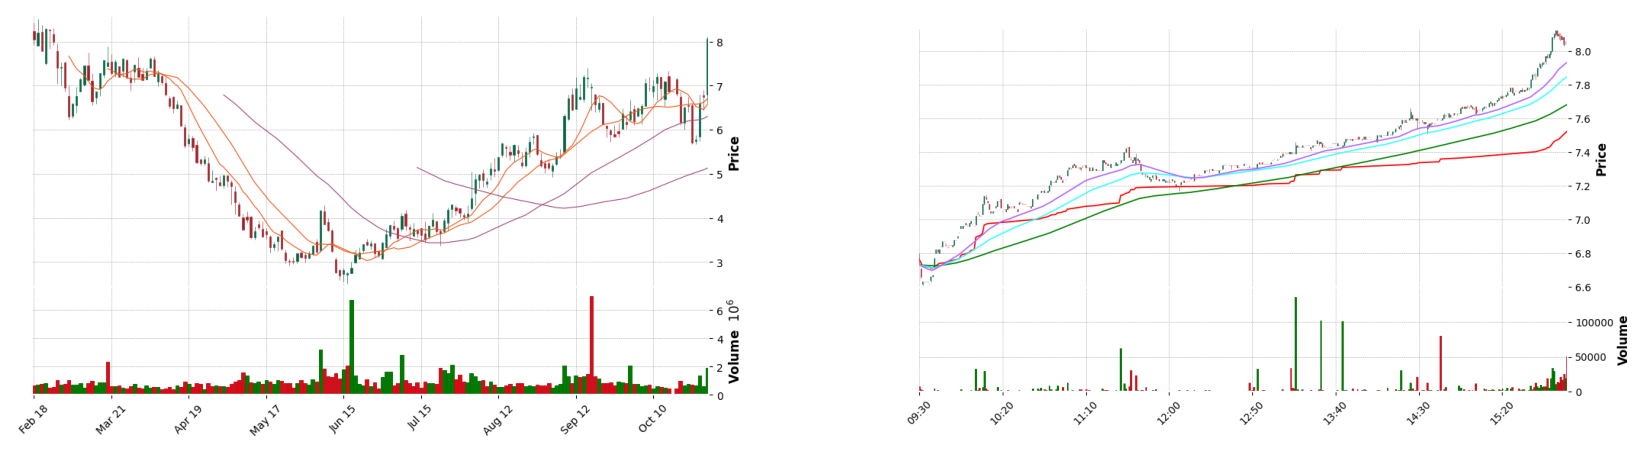

VTYX 2022-10-28 (21.8%)


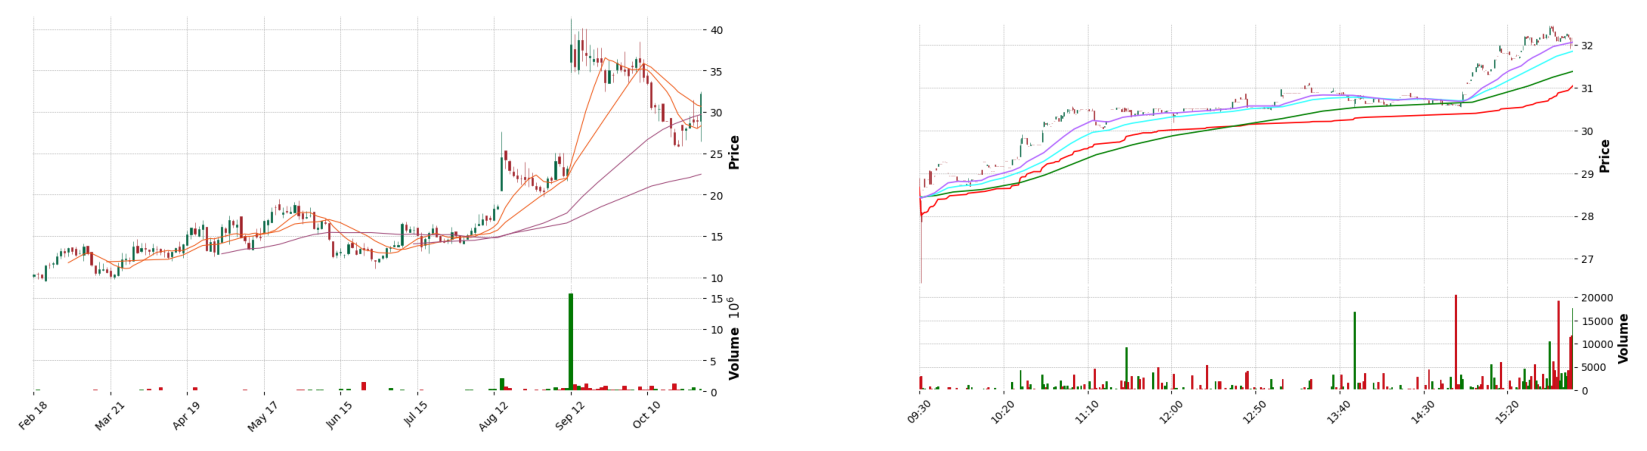

EGHT 2022-10-28 (20.4%)


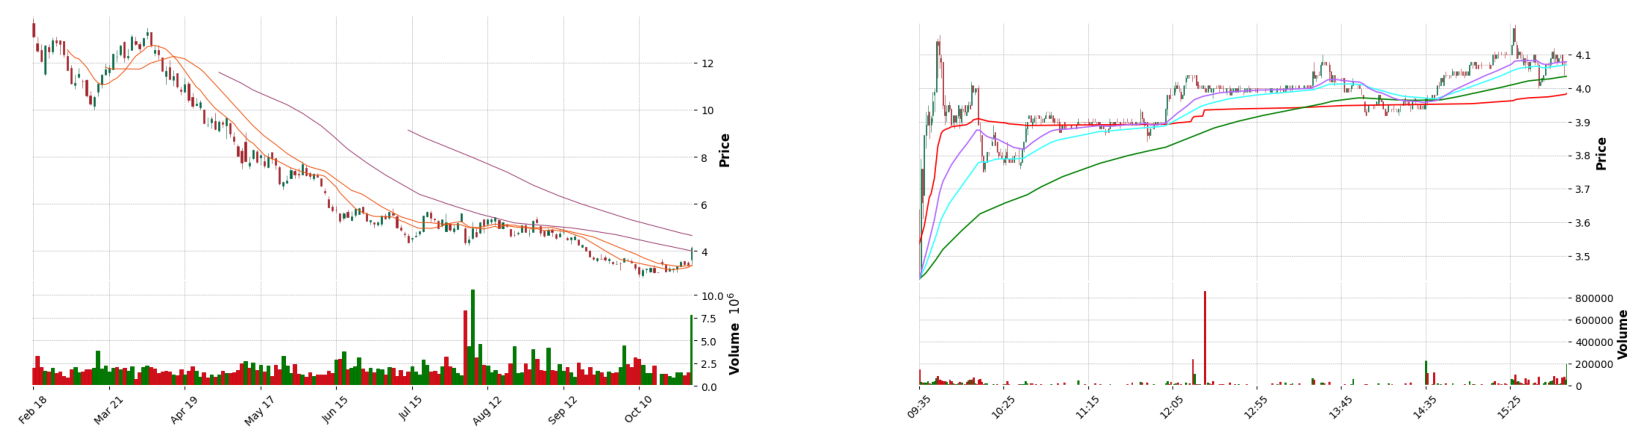

NUVL 2022-10-28 (17.8%)


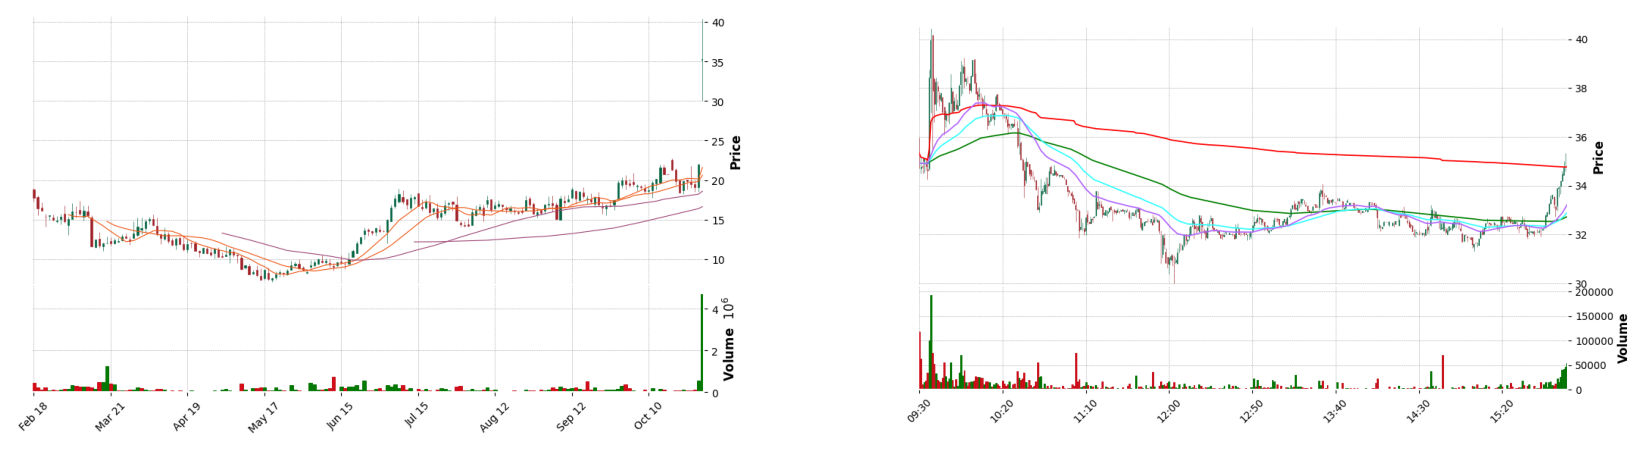

NGM 2022-10-28 (16.6%)


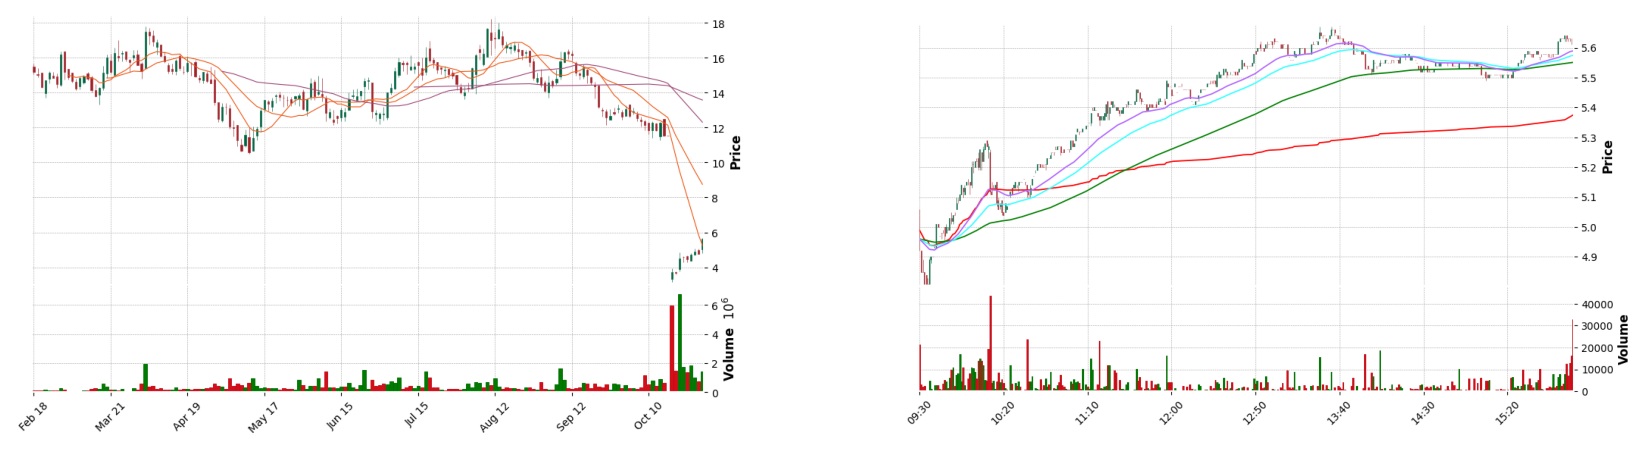

PACB 2022-10-28 (15.6%)


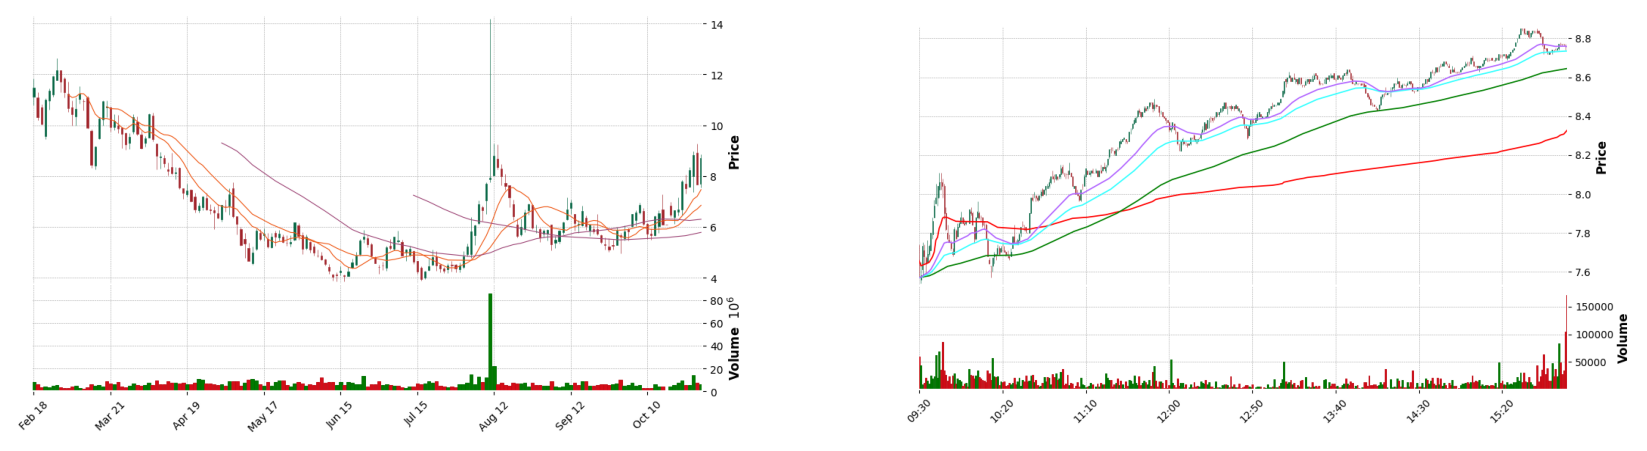

TCBX 2022-10-28 (14.5%)


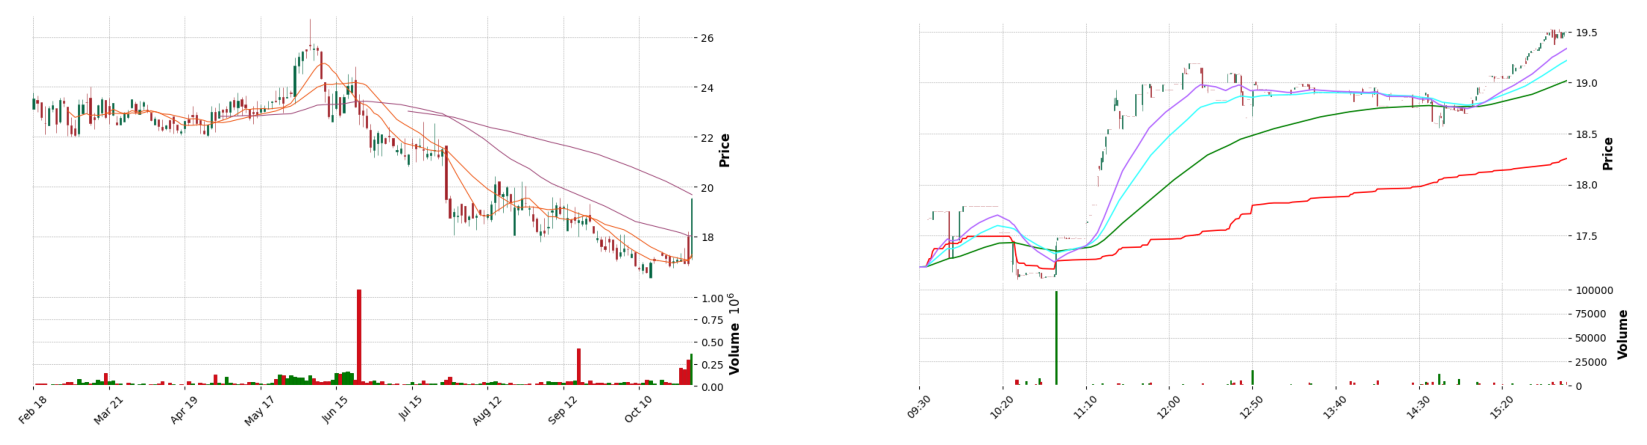

GTLS 2022-10-28 (14.0%)


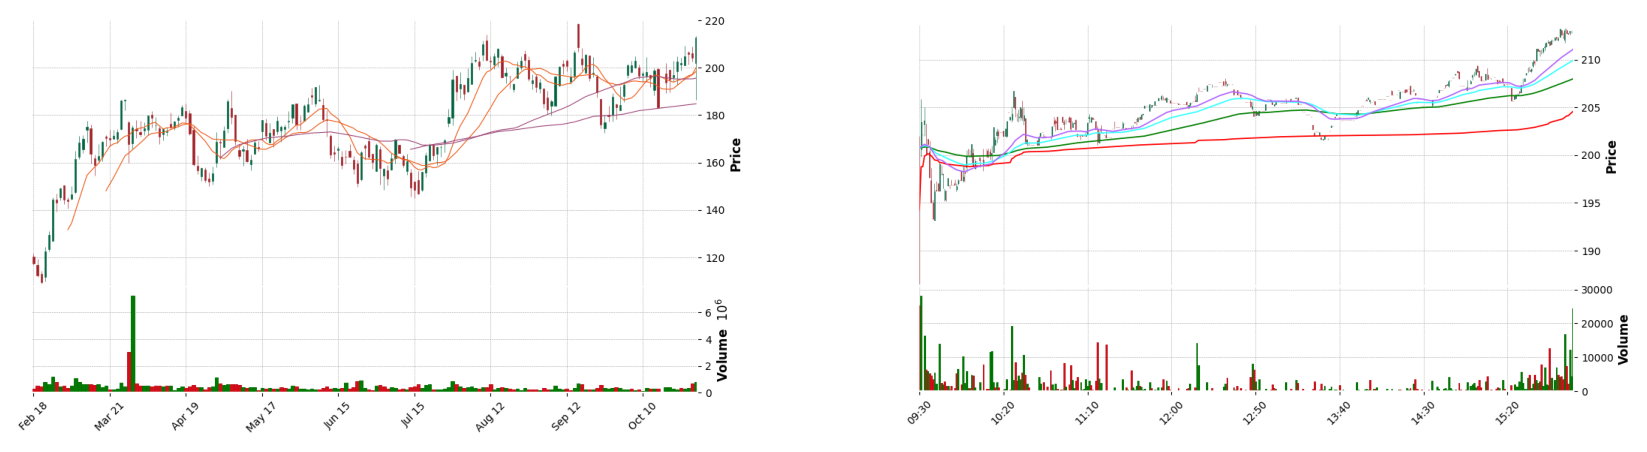

PRTA 2022-10-28 (13.8%)


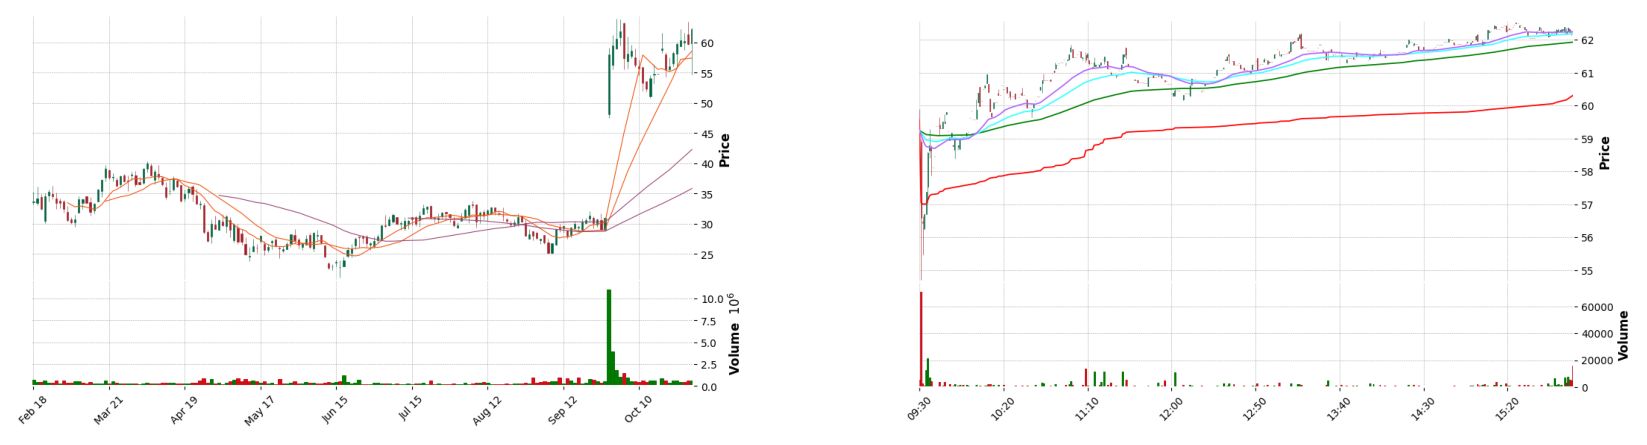

COHU 2022-10-28 (13.6%)


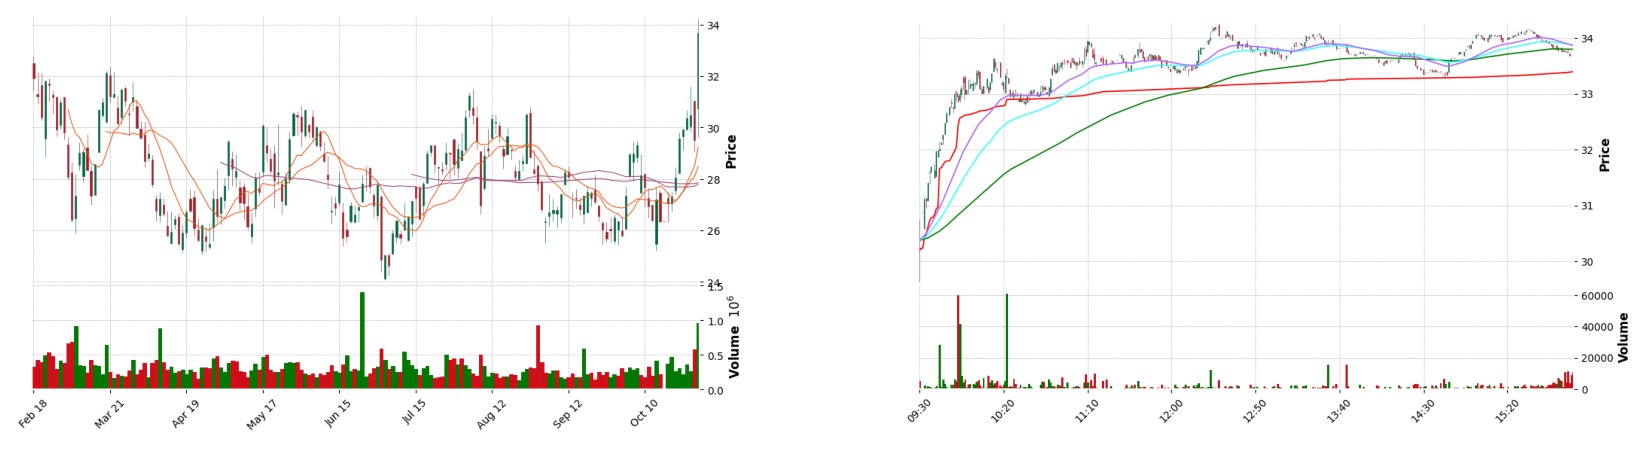

VERV 2022-10-28 (13.1%)


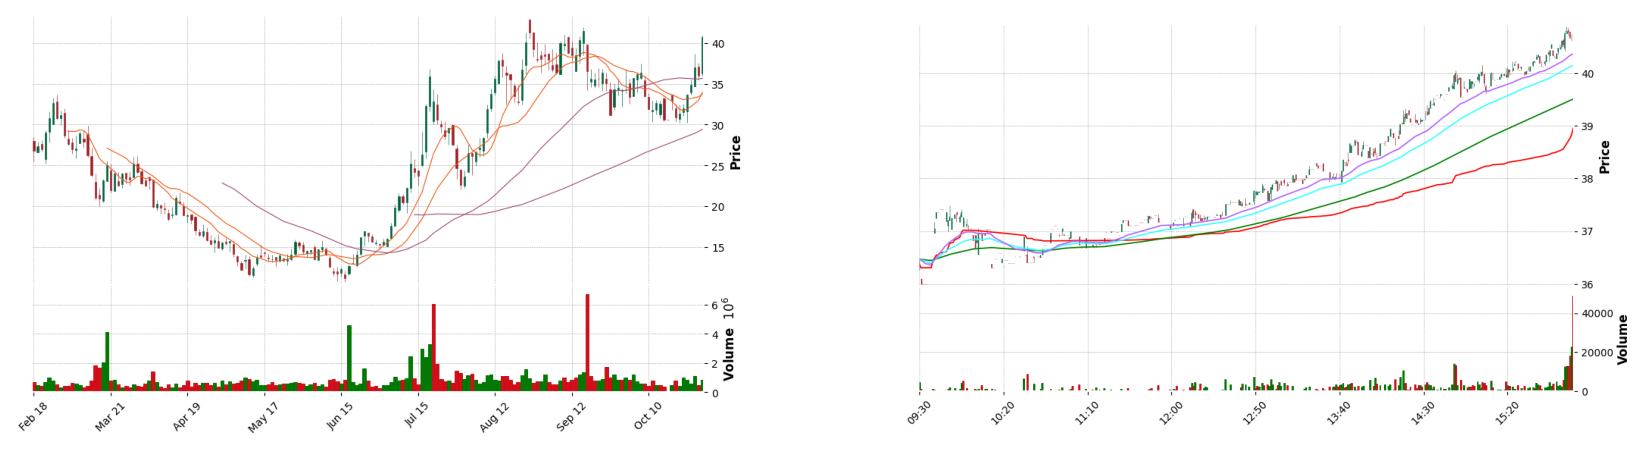

VERA 2022-10-28 (12.9%)


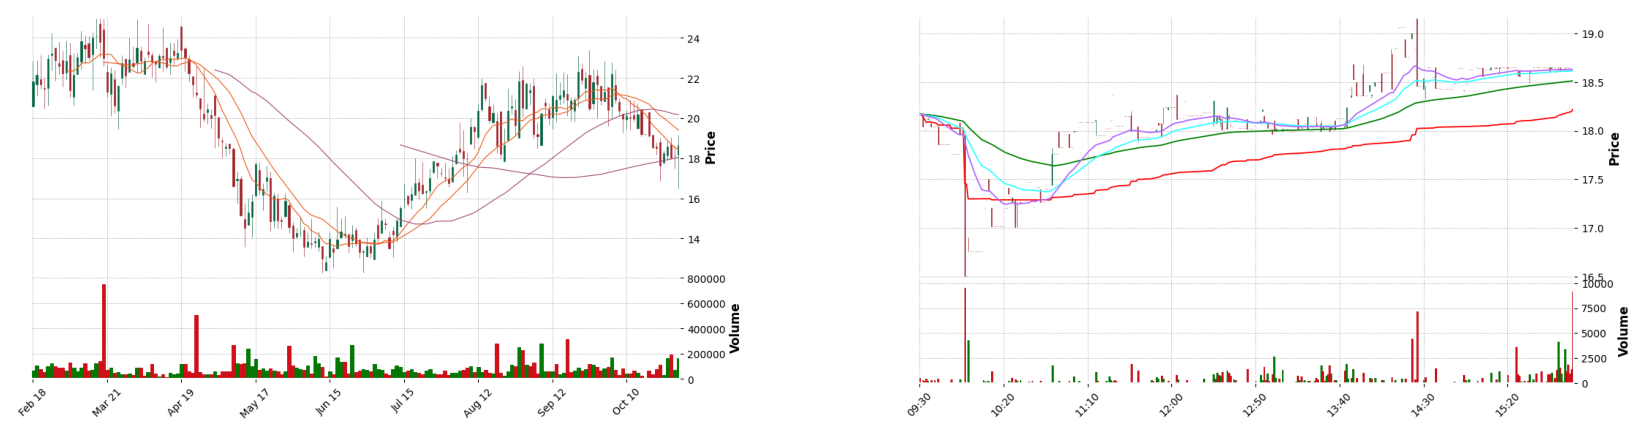

KYMR 2022-10-28 (12.5%)


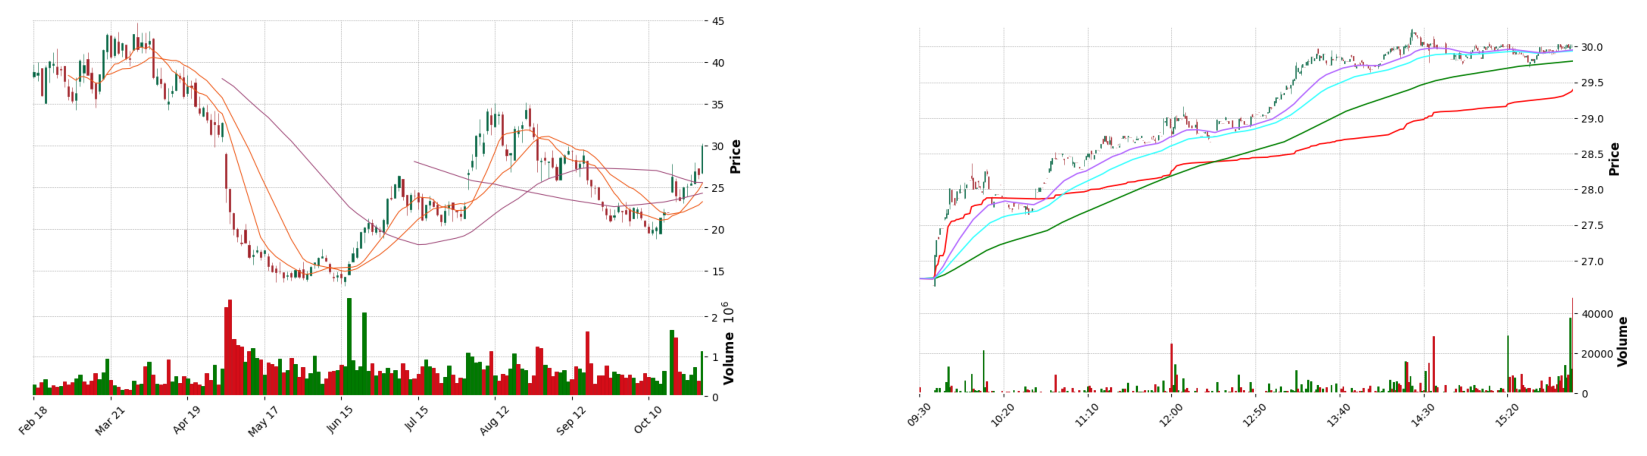

LABU 2022-10-28 (12.3%)


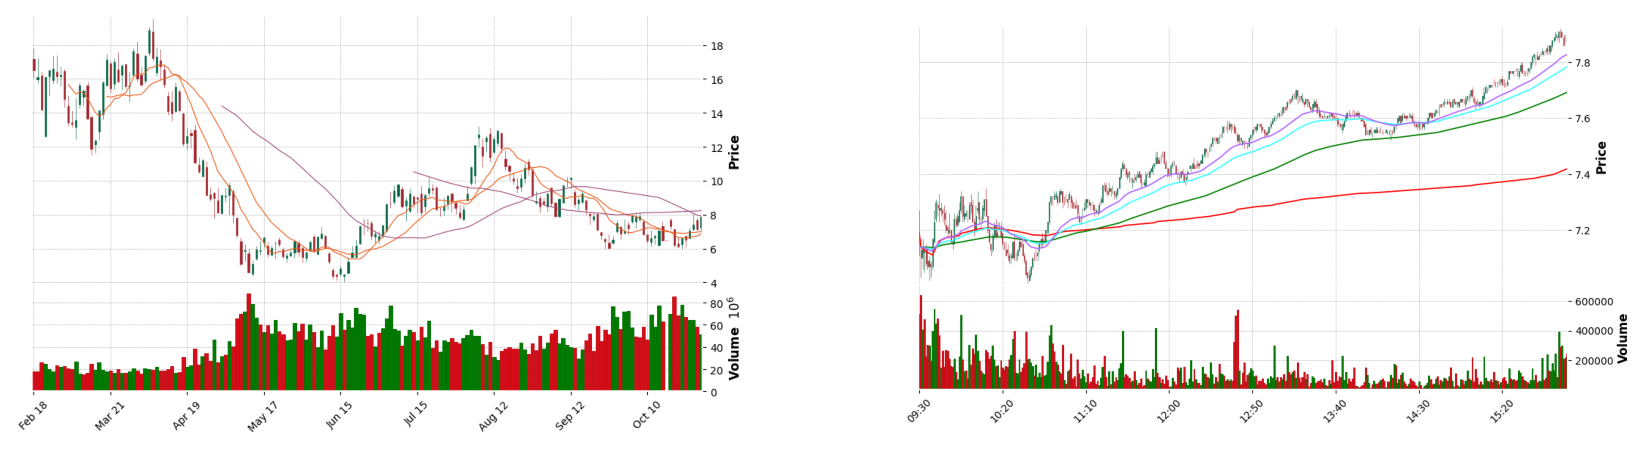

SOXL 2022-10-28 (11.9%)


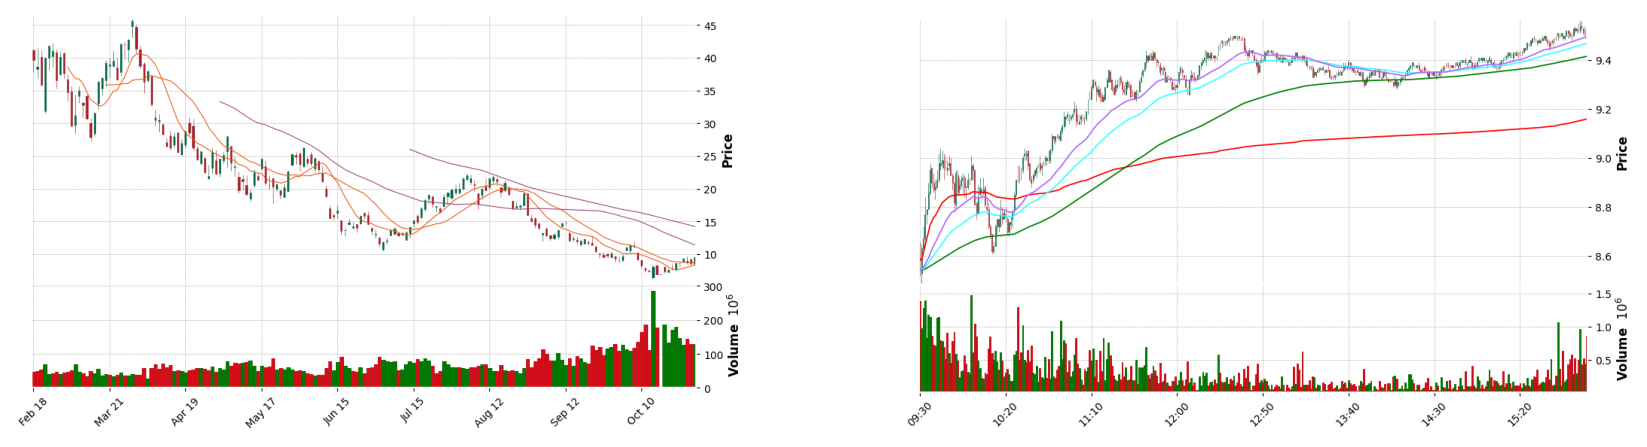

FLWS 2022-10-28 (11.5%)


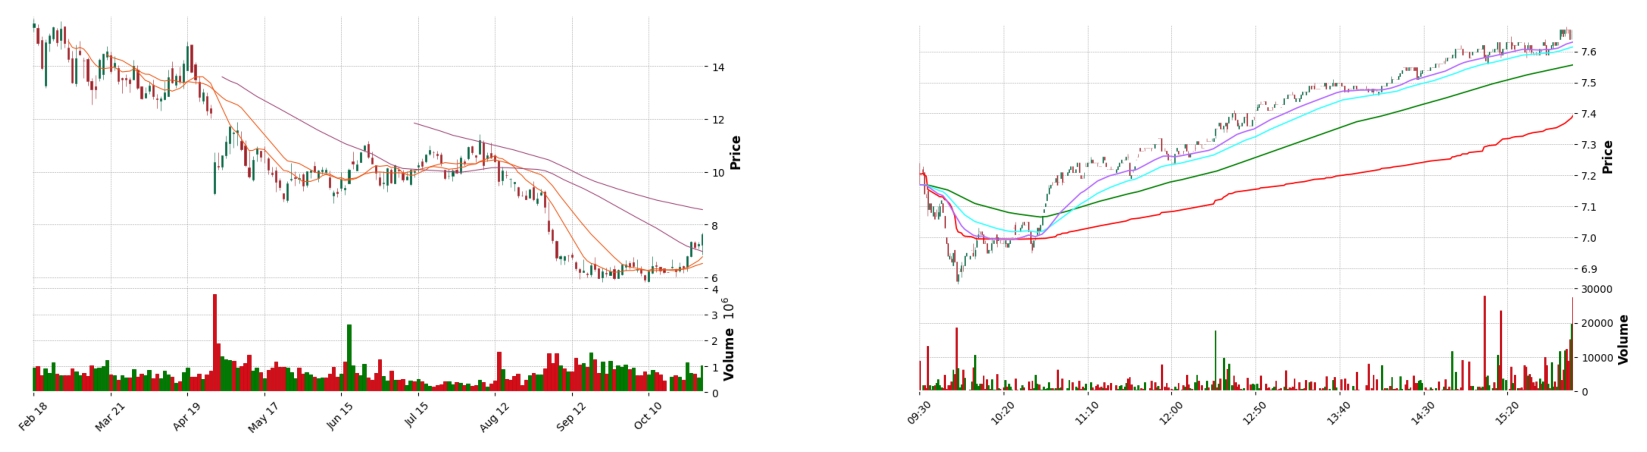

QTRX 2022-10-28 (11.5%)


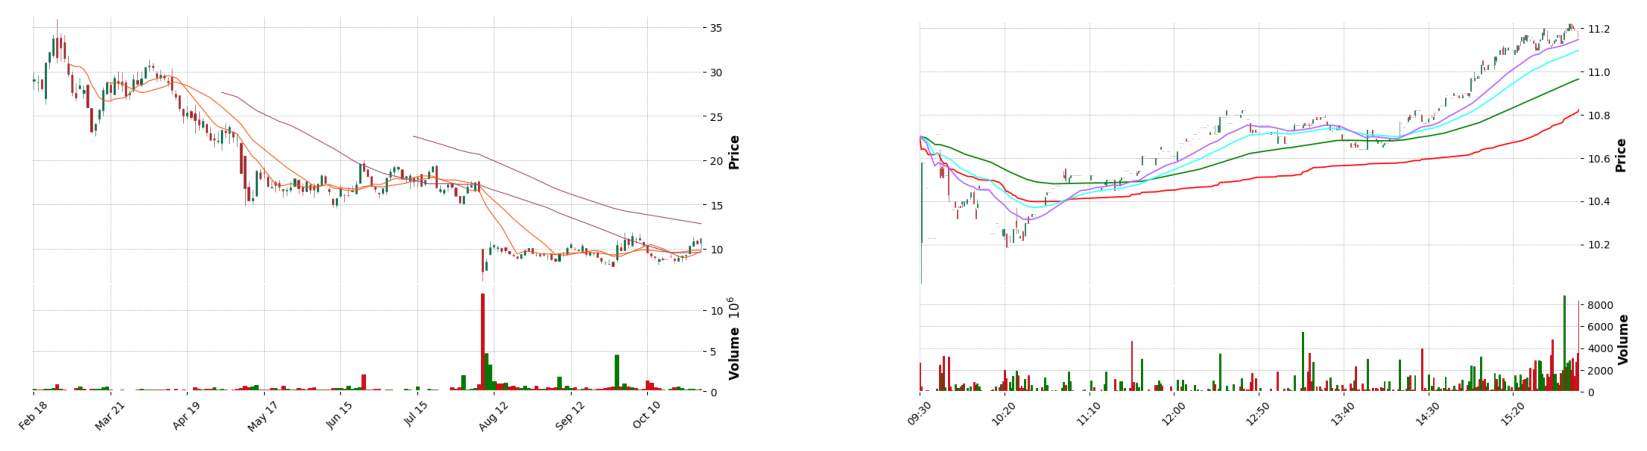

MIRM 2022-10-28 (11.3%)


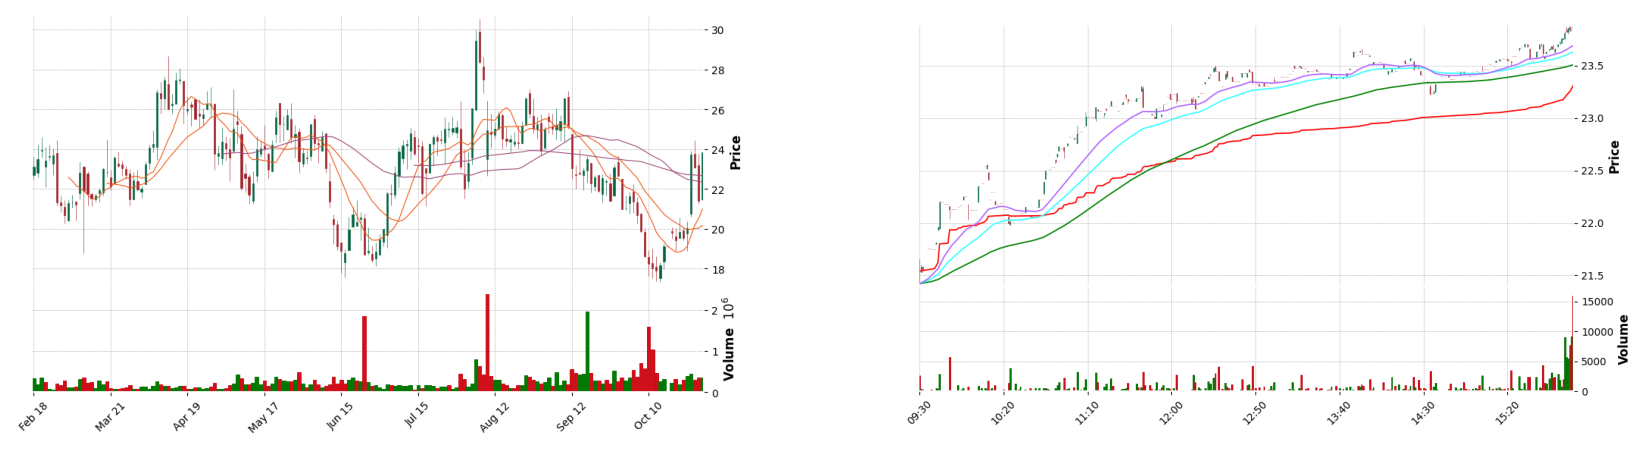

LOB 2022-10-28 (11.2%)


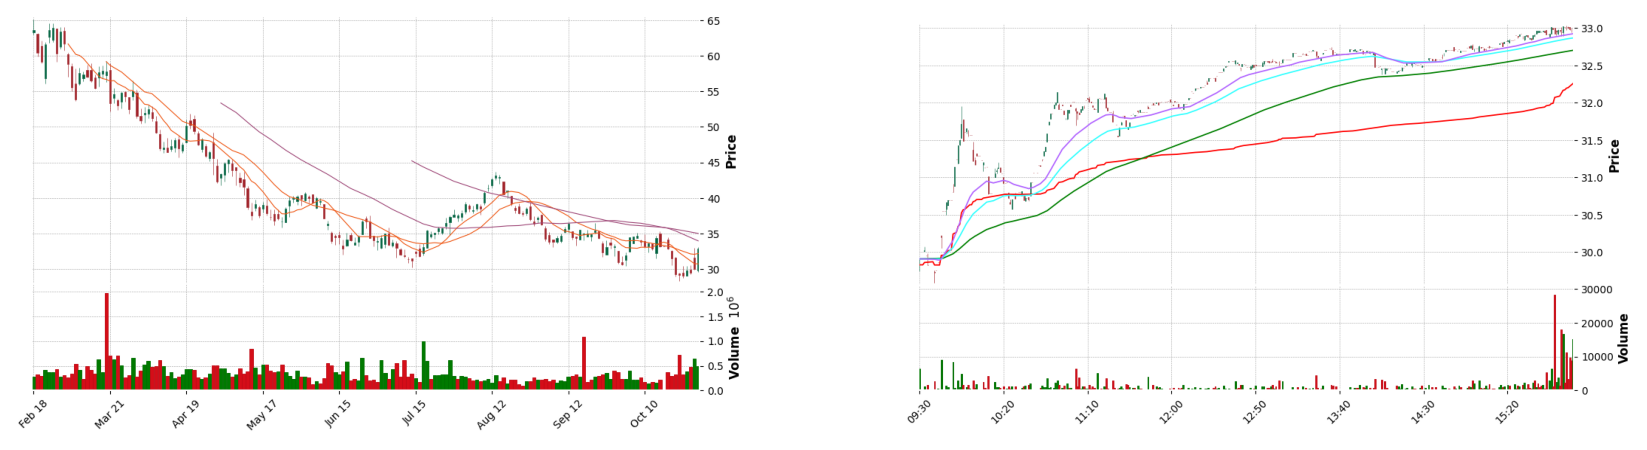

TECL 2022-10-28 (11.2%)


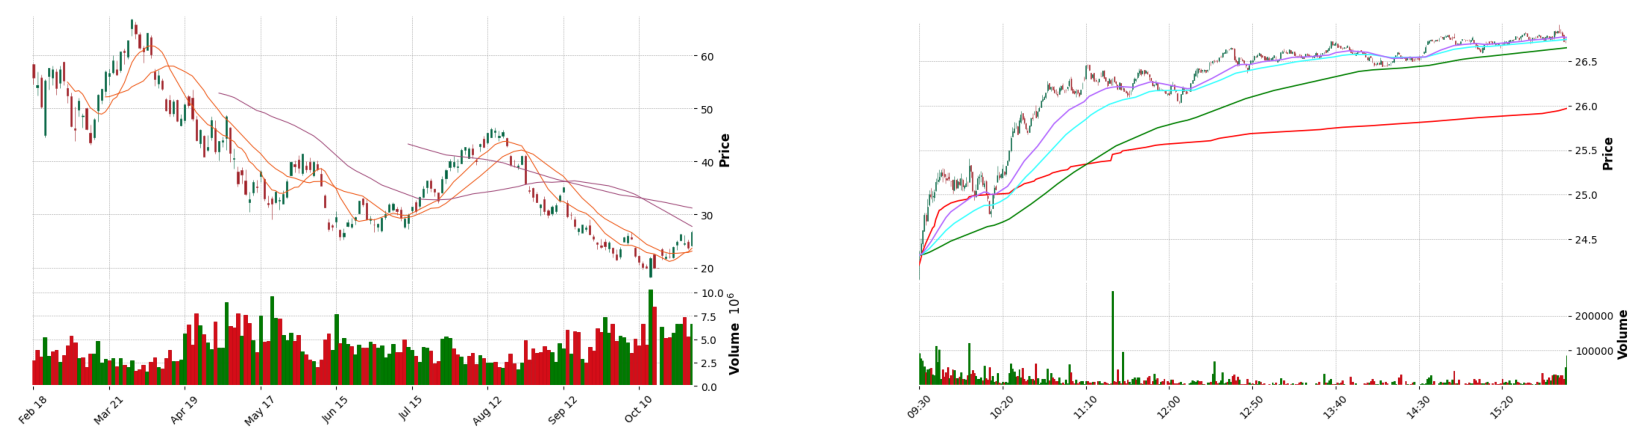

In [6]:
try:
  r = requests.get(baseurl + '/toplongsoftheday', data={})
  df = pd.DataFrame(r.json()['payload'])
except Exception as e:
  logging.error(f"Exception Name: {type(e).__name__}")
  logging.error(f"Exception Desc: {e}")
  print(r)
  print(r.text)
  raise e

print(df.head)
df['tickTime'] = pd.to_datetime(df['tickTime'])


for index, row in df.iterrows():
    
    ######################################################
    # fetch daily
    ######################################################
    start = (row['tickTime'] + pd.DateOffset(days=-252)).strftime('%Y-%m-%d')
    end = (row['tickTime'] + pd.DateOffset(days=3)).strftime('%Y-%m-%d')

    url = baseurl + '/chart/' + row['symbol'] + '/d?from=' + encodeUrl(start) + '&to=' + encodeUrl(end)
    chartResponse = requests.get(url)
    chartDf = None
    try:
      chartDf = pd.DataFrame(chartResponse.json()['payload'])
    except Exception as e:
      print(e.__class__)
      print(e)
      print(chartResponse)
      print(chartResponse.text)
      break
    
    chartDf.tickTime = pd.to_datetime(chartDf.tickTime)
    chartDf = chartDf.set_index('tickTime')

    entry = row['tickTime'].strftime('%Y-%m-%d')

    print(row['symbol'] + ' ' + row['tickTime'].strftime('%Y-%m-%d') + ' (' + str(round(100*row['pct'],1)) + '%)')
    
    imgDailyPlot = io.BytesIO()
    mpf.plot(chartDf[start:end], 
             type='candle', 
             volume=True, 
             mav=(10,20,50,100,200),
             tight_layout=True, 
             figratio=(16,9),
             savefig=imgDailyPlot,
             style='charles')
    _ = imgDailyPlot.seek(0)

    ######################################################
    # fetch intraday
    ######################################################
    start = (row['tickTime']).strftime('%Y-%m-%d')
    end = (row['tickTime']).strftime('%Y-%m-%d')
    url = baseurl + '/chart/' + row['symbol'] + '/1m?from=' + encodeUrl(start) + '&to=' + encodeUrl(end)

    imgIntradayPlot = io.BytesIO()
    chartDf = None
    try:
      chartResponse = requests.get(url)
      if chartResponse.status_code != 200:
        imgIntradayPlot = 'dummy.png'
      else:
        chartDf = pd.DataFrame(chartResponse.json()['payload'])
        chartDf.tickTime = pd.to_datetime(chartDf.tickTime)
        chartDf = chartDf.set_index('tickTime')
        chartDf.drop(['id', 'symbol','created'], axis=1, inplace=True)

        chartDf['VWAP'] = (chartDf.volume * (chartDf.high + chartDf.low) / 2).cumsum() / chartDf.volume.cumsum()

        addplot  = [
            mpf.make_addplot(chartDf['VWAP'], color="red"),
            mpf.make_addplot(chartDf['close'].ewm(span=150, adjust=False).mean(), color='green'),
            mpf.make_addplot(chartDf['close'].ewm(span=63, adjust=False).mean(), color='#33ffff'),
            mpf.make_addplot(chartDf['close'].ewm(span=36, adjust=False).mean(), color='#b266ff')
        ]

        mpf.plot(chartDf[start:end], 
                type='candle', 
                volume=True, 
                tight_layout=True, 
                figratio=(16,9),
                addplot=addplot,
                savefig=imgIntradayPlot,
                style='charles')
        _ = imgIntradayPlot.seek(0)
    except Exception as e:
      print(e.__class__)
      print(e)
      print(chartResponse)
      print(chartResponse.text)
      continue

    ######################################################
    # render candlestick & perf charts
    ######################################################
    # daily & intraday charts
    img1 = m_img.imread(imgDailyPlot)
    img2 = m_img.imread(imgIntradayPlot)
    fig = plt.figure(figsize=(21,14))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax1.set_axis_off()
    ax2.set_axis_off()
    ax1.imshow(img1)
    ax2.imshow(img2)
    plt.show()